In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

import glob
import time
import cv2

from sklearn.utils import shuffle


%matplotlib inline

In [2]:
from feature import *

cars, notcars = list_files(data_dir='./data')

print("Original - Car image count: {}, non-car image count: {}".format(len(cars), len(notcars)))

Original - Car image count: 8792, non-car image count: 8968


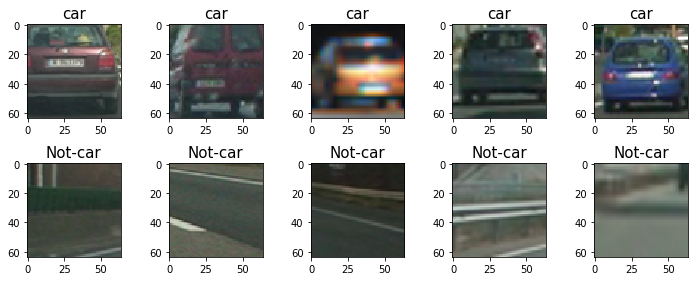

In [3]:
def show_sample(cars, notcars):
    r, c = (2, 5)
    
    f, ax = plt.subplots(r, c, figsize=(10, 4))
    f.tight_layout()
    
    ax = ax.ravel()

    # Make it reproducible
    np.random.seed(1)
    
    for i in range(0, c):
        idx = np.random.randint(0, 2000)

        ax[i].imshow(mpimg.imread(cars[idx]))
        ax[i].set_title("car", fontsize=15)

        ax[c + i].imshow(mpimg.imread(notcars[idx]))
        ax[c + i].set_title('Not-car', fontsize=15)
    
    plt.savefig('./output_images/car_not_car.png')
    plt.show()
    
show_sample(cars, notcars)

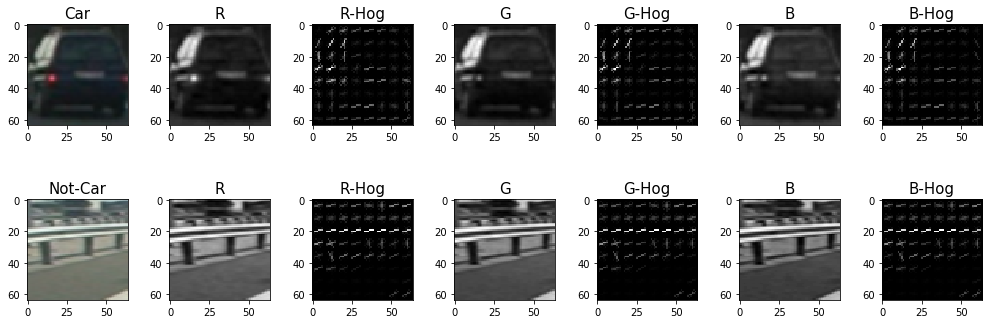

In [7]:
from feature import *

params = Params(color_space='YCrCb', hog_feat=True)

def show_hog_feature_sample(color_space, params):    
    car_image = mpimg.imread(cars[1150])
    notcar_image = mpimg.imread(notcars[1150])
    
    r, c = (2, 7)

    f, ax = plt.subplots(r, c, figsize=(14, 5))
    f.tight_layout()

    ax = ax.ravel()
    
    for i, img, title in zip(range(0, 2), [car_image, notcar_image], ['Car', 'Not-Car']):
        ax[i * c].imshow(img)
        ax[i * c].set_title(title, fontsize=15)
        
        img = convert_color_space(img, ''.join(color_space))
        
        for channel in range(0, 3):
            channel_image = img[:,:,channel]
            
            ax[i*c + channel*2 + 1].imshow(channel_image, cmap='gray')
            ax[i*c + channel*2 + 1].set_title("{}".format(color_space[channel]), fontsize=15)
            
            _, hog_image = get_hog_features(channel_image, orient=params.orient, 
                                         pix_per_cell=params.pix_per_cell,
                                         cell_per_block=params.cell_per_block,
                                         vis=True, feature_vec=True)
            ax[i*c + channel*2 + 2].imshow(hog_image, cmap='gray')
            ax[i*c + channel*2 + 2].set_title("{}-Hog".format(color_space[channel]), fontsize=15)
            
    plt.savefig('./output_images/HOG_{}.jpg'.format(''.join(color_space)))

show_hog_feature_sample(color_space=['R', 'G', 'B'], params=params)

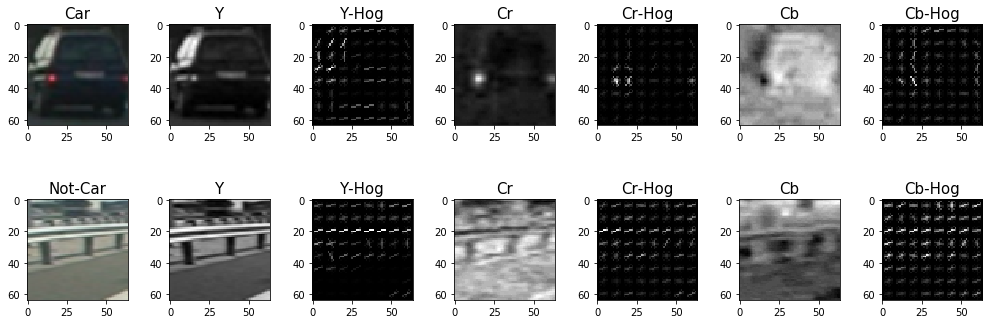

In [8]:
show_hog_feature_sample(color_space=['Y', 'Cr', 'Cb'], params=params)

In [9]:
from training import *

# set the sample size
sample_size = min(len(cars), len(notcars))
_cars = cars[0:sample_size]
_notcars = notcars[0:sample_size]

params = Params(color_space='YCrCb', hog_feat=True)

X_train, X_test, y_train, y_test = prepare_dataset(_cars, _notcars, params, ratio=0.2)
X_scaler, X_train, X_test = normalize(X_train, X_test)

print('Using:', params.orient,'orientations', params.pix_per_cell, 
      'pixels per cell and', params.cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Check the training time for the SVC
t=time.time()
svc = train_svc_model(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
6.07 Seconds to train SVC...
Test Accuracy of SVC =  0.9898


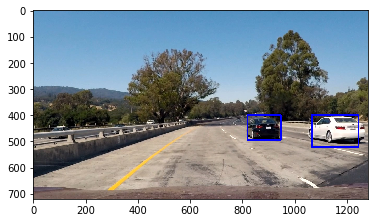

In [53]:
from detection import *

image = read_image('./test_images/test1.jpg')
img = detect_cars(image)
plt.imshow(img)

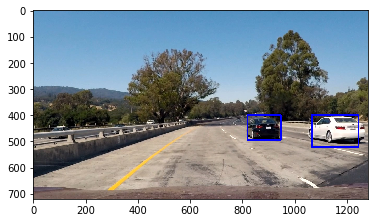

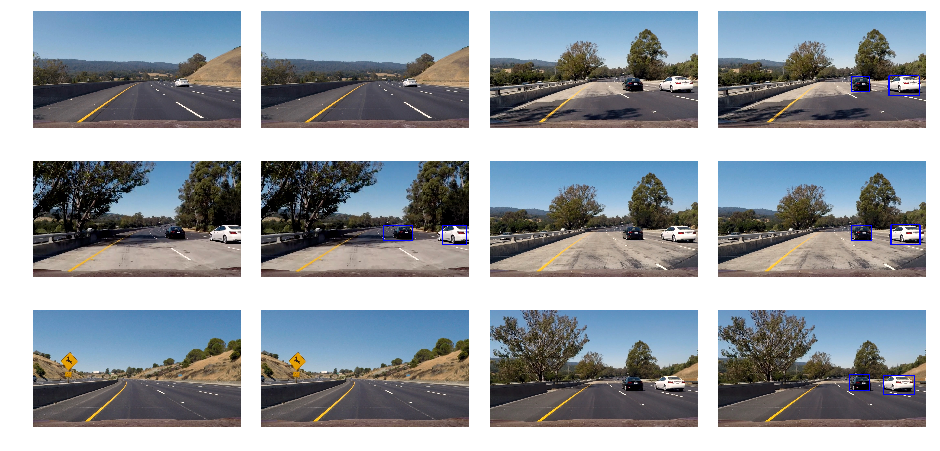

In [54]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 4, figsize=(16,8))
fig.subplots_adjust(hspace = .1, wspace=.1)
axs = axs.ravel()

for i, im in enumerate(test_images):
    image = read_image(im)

    axs[i * 2].imshow(image)
    axs[i * 2].axis('off')
    
    axs[i * 2 + 1].imshow(detect_cars(image))
    axs[i * 2 + 1].axis('off')

In [56]:
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [57]:
output = 'test_result.mp4'
clip = VideoFileClip("test_video.mp4")
video_clip = clip.fl_image(detect_cars)
%time video_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_result.mp4
[MoviePy] Writing video test_result.mp4


 97%|█████████▋| 38/39 [00:17<00:00,  2.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_result.mp4 

CPU times: user 1min 8s, sys: 441 ms, total: 1min 8s
Wall time: 18.4 s


In [ ]:
output = 'result.mp4'
clip = VideoFileClip("project_video.mp4")#.subclip(0,10)
video_clip = clip.fl_image(detect_cars)
%time video_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


 45%|████▍     | 564/1261 [04:39<05:45,  2.01it/s]

## 